<a href="https://colab.research.google.com/github/aline-fortaleza/titanic-kmeans-dbscan-kprototypes/blob/main/K_Means_DBSCAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mini-projeto de Clusterização: K-Means, K-Prototypes e DBSCAN no Dataset Titanic

**Objetivo:** Este projeto foca na aplicação de algoritmos de aprendizado não supervisionado para identificar padrões e agrupar passageiros do Titanic com características similares.Conforme as diretrizes, a variável `Survived` foi removida para garantir uma análise puramente não supervisionada

**Algoritmos Utilizados:**
* K-Means
* K-Prototypes
* DBSCAN

**Ferramentas:** Python, Jupyter Notebook, Scikit-learn, Pandas, Matplotlib, Seaborn e Kmodes.

Alunos:

Alice Buarque Cadete (abc3)

Aline Fortaleza Ferreira da Silva (affs2)

Arthur Alves de Marsaro (aam4)

Beatriz Galhardo Carneiro Leão (bgcl)

Danilo Lima de Carvalho (dlc3)


#Extração dos Dados

In [ ]:
!pip install -q kaggle
!pip install kmodes

In [ ]:
# Importando bibliotecas para manipulação e análise de dados
import pandas as pd
import numpy as np

# Importando bibliotecas para visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns

# Importando algoritmos de clusterização
from sklearn.cluster import KMeans, DBSCAN
from kmodes.kprototypes import KPrototypes

# Importando métricas para avaliação de clusters
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Importando ferramentas para pré-processamento e modelagem
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_text

# Configurações para melhor visualização dos gráficos
%matplotlib inline
sns.set_style('whitegrid')
plt.style.use('seaborn-v0_8-deep')

print("Bibliotecas importadas com sucesso!")


Bibliotecas importadas com sucesso!


In [ ]:
from google.colab import files
files.upload()

# Carregando o dataset em um DataFrame do Pandas
try:
    # ATENÇÃO: Utilizar a base enviada via Classroom, que já vem sem o alvo.
    # Se estiver usando a base original do Kaggle, lembre-se de remover a coluna 'Survived'.
    df_train = pd.read_csv('train.csv')
    print("Dataset carregado com sucesso!")
except FileNotFoundError:
    print("Erro: Arquivo 'train.csv' não encontrado. Verifique o nome do arquivo enviado.")

# REMOVENDO O RÓTULO PARA ANÁLISE NÃO SUPERVISIONADA
if 'Survived' in df_train.columns:
    df_train = df_train.drop('Survived', axis=1)
    print("Coluna 'Survived' removida para a análise não supervisionada.")

df_train.head()

Saving gender_submission.csv to gender_submission.csv
Saving test.csv to test.csv
Saving train.csv to train.csv
Dataset carregado com sucesso!
Coluna 'Survived' removida para a análise não supervisionada.


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#Análise Exploratória e Pré-processamento dos Dados

Antes de aplicar os algoritmos, é crucial entender e preparar os dados. Esta etapa envolve:
1.  **Análise Descritiva:** Visualizar a distribuição das variáveis.
2.  **Tratamento de Dados Faltantes:** Lidar com valores ausentes nas colunas `Age` e `Cabin`.
3.  **Engenharia de Features:** Criar novas variáveis que possam ser úteis para a clusterização.
4.  **Codificação de Variáveis Categóricas:** Transformar variáveis como `Sex` e `Embarked` em formato numérico.
5. **Normalização:** Escalonar os dados numéricos, um passo fundamental para algoritmos baseados em distância

In [ ]:
# Tratamento de dados faltantes (exemplo com a mediana para 'Age')
df_train['Age'].fillna(df_train['Age'].median(), inplace=True)

# Preenchendo 'Embarked' com a moda
df_train['Embarked'].fillna(df_train['Embarked'].mode()[0], inplace=True)

# Removendo colunas que não contribuem para a análise de padrões de passageiros
df_train_processed = df_train.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])

# Codificação da variável categóricaa sex (One-Hot Encoding)
df_train_processed = pd.get_dummies(df_train_processed, columns=['Sex'], drop_first=True)

#Codificação da variável categórica embarked
df_train_processed['Embarked'] = df_train_processed['Embarked'].replace({'S': 1, 'C': 2, 'Q': 3})

# Normalização dos dados numéricos
numeric_cols = df_train_processed.select_dtypes(include=np.number).columns
scaler = StandardScaler()
df_train_processed[numeric_cols] = scaler.fit_transform(df_train_processed[numeric_cols])

print("Pré-processamento concluído.")
df_train_processed.head()

Pré-processamento concluído.


/tmp/ipython-input-2415780171.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train['Age'].fillna(df_train['Age'].median(), inplace=True)
/tmp/ipython-input-2415780171.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=

,Pclass,Age,SibSp,Parch,Fare,Embarked,Sex_male
0,0.827377,-0.565736,0.432793,-0.473674,-0.502445,-0.568837,True
1,-1.566107,0.663861,0.432793,-0.473674,0.786845,1.005181,False
2,0.827377,-0.258337,-0.474545,-0.473674,-0.488854,-0.568837,False
3,-1.566107,0.433312,0.432793,-0.473674,0.420730,-0.568837,False
4,0.827377,0.433312,-0.474545,-0.473674,-0.486337,-0.568837,True


#Aplicação dos Algoritmos de Clusterização

### K-Means

O K-Means é um algoritmo que agrupa os dados tentando separar as amostras em *k* grupos de variância igual. Ele funciona bem com dados puramente numéricos.

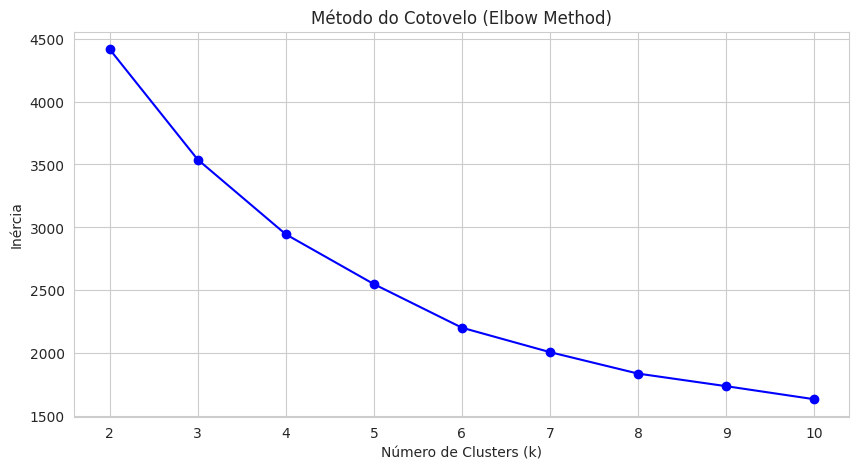

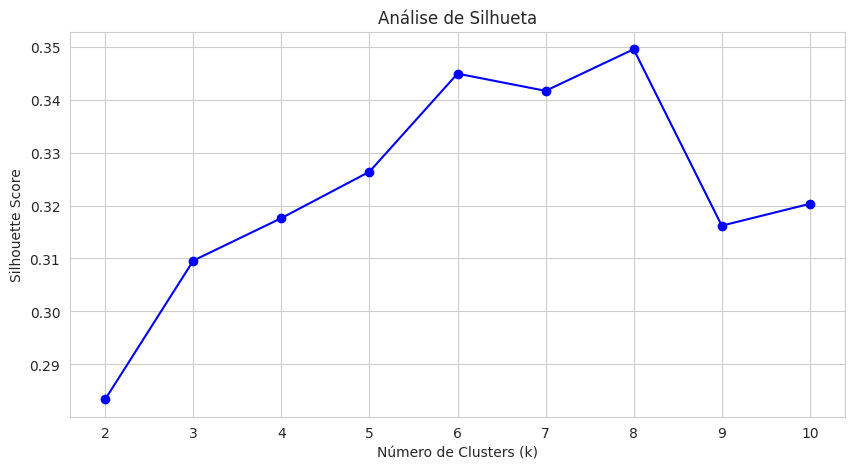

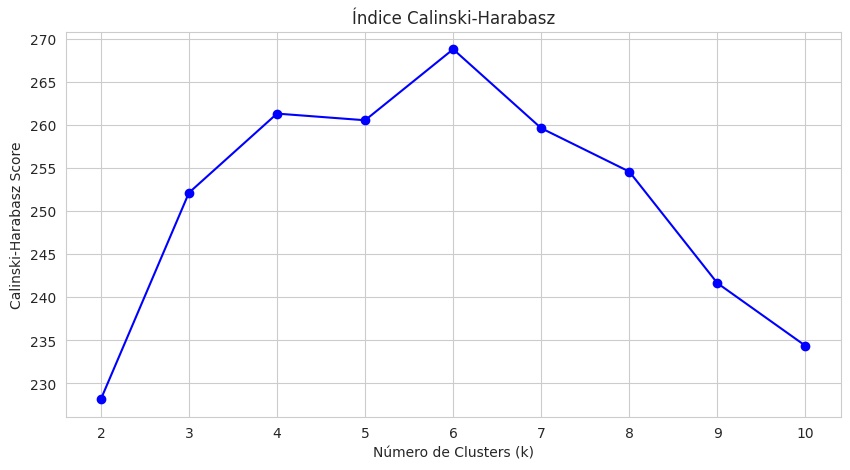

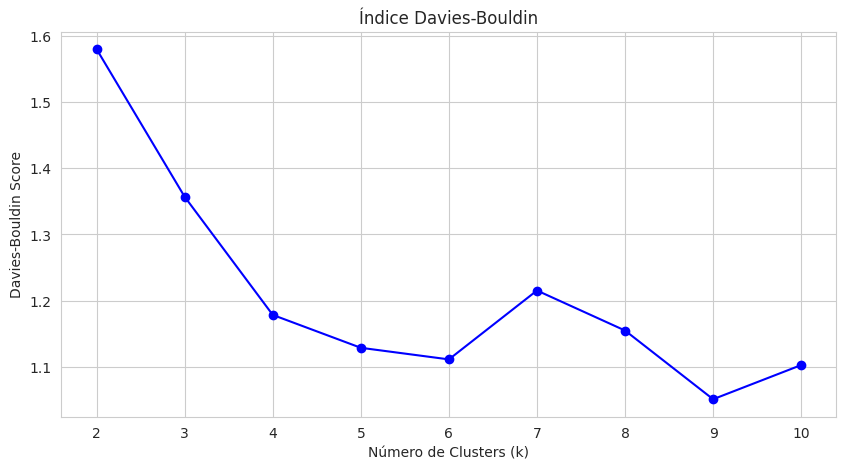

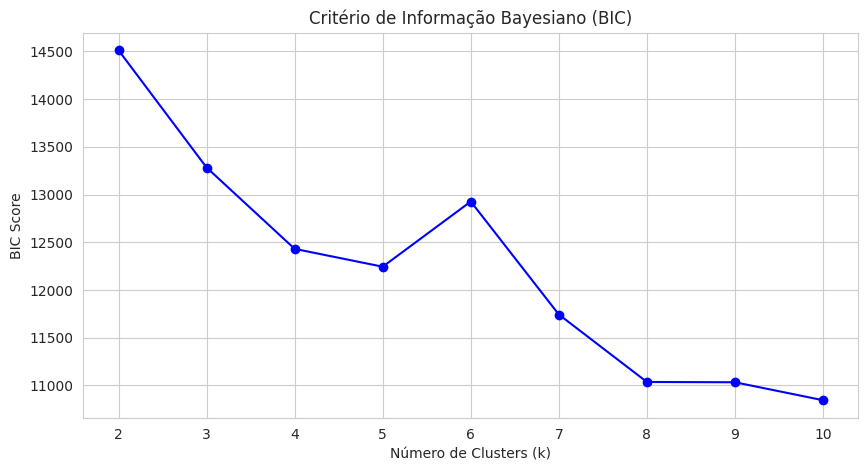

In [ ]:
# Importando todas as bibliotecas e métricas necessárias
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# --- Identificando o número ótimo de clusters para o K-Means ---
# Métricas: Elbow, Calinski-Harabasz, Davies-Bouldin, Silhouette e BIC [cite_end]

# Listas para armazenar os resultados das métricas
inertia = []
silhouette_scores = []
calinski_scores = []
davies_bouldin_scores = []
bic_scores = []

# Range de clusters para testar
k_range = range(2, 11)

for k in k_range:
    # --- K-Means ---
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_train_processed)
    labels = kmeans.labels_

    # 1. Inércia (Elbow Method)
    inertia.append(kmeans.inertia_)

    # 2. Silhouette Score
    silhouette_scores.append(silhouette_score(df_train_processed, labels))

    # 3. Calinski-Harabasz Score
    calinski_scores.append(calinski_harabasz_score(df_train_processed, labels))

    # 4. Davies-Bouldin Score
    davies_bouldin_scores.append(davies_bouldin_score(df_train_processed, labels))

    # 5. BIC (usando Gaussian Mixture Model como aproximação para K-Means)
    gmm = GaussianMixture(n_components=k, random_state=42, covariance_type='spherical')
    gmm.fit(df_train_processed)
    bic_scores.append(gmm.bic(df_train_processed))

# --- Plotando os resultados ---

# 1. Gráfico do Cotovelo (Elbow)
plt.figure(figsize=(10, 5))
plt.plot(k_range, inertia, 'bo-')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inércia')
plt.title('Método do Cotovelo (Elbow Method)')
plt.show()

# 2. Gráfico do Silhouette Score
plt.figure(figsize=(10, 5))
plt.plot(k_range, silhouette_scores, 'bo-')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Análise de Silhueta')
plt.show()

# 3. Gráfico do Calinski-Harabasz Score
plt.figure(figsize=(10, 5))
plt.plot(k_range, calinski_scores, 'bo-')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Calinski-Harabasz Score')
plt.title('Índice Calinski-Harabasz')
plt.show()

# 4. Gráfico do Davies-Bouldin Score
plt.figure(figsize=(10, 5))
plt.plot(k_range, davies_bouldin_scores, 'bo-')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Davies-Bouldin Score')
plt.title('Índice Davies-Bouldin')
plt.show()

# 5. Gráfico do BIC
plt.figure(figsize=(10, 5))
plt.plot(k_range, bic_scores, 'bo-')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('BIC Score')
plt.title('Critério de Informação Bayesiano (BIC)')
plt.show()

 Algoritmo de Decisão para o Valor de K

Para determinar o valor ideal de k de forma mais objetiva, este algoritmo analisa os resultados das cinco métricas calculadas. Para as métricas baseadas em score (Silhouette, Calinski-Harabasz, Davies-Bouldin, BIC), ele encontra o valor de k que maximiza ou minimiza o score. Para o método do cotovelo, ele calcula o ponto de máxima curvatura da linha de inércia.

Finalmente, ele conta qual valor de k foi mais recomendado e o sugere como a melhor escolha, conforme a diretriz de usar o critério da maioria.

In [ ]:
import numpy as np
from statistics import mode

# --- 1. Encontrando o "cotovelo" (Elbow) de forma programática ---
# Normalizamos os valores de inércia para ficarem entre 0 e 1
inertia_normalized = (inertia - np.min(inertia)) / (np.max(inertia) - np.min(inertia))

# Calculamos a distância de cada ponto à linha que liga o primeiro e o último ponto
# O "cotovelo" é o ponto mais distante dessa linha
distances = []
for i in range(len(k_range)):
    # Coordenadas dos pontos
    x1, y1 = k_range[0], inertia_normalized[0]
    x2, y2 = k_range[-1], inertia_normalized[-1]
    x0, y0 = k_range[i], inertia_normalized[i]

    # Fórmula da distância de um ponto a uma reta
    numerator = abs((y2 - y1) * x0 - (x2 - x1) * y0 + x2 * y1 - y2 * x1)
    denominator = np.sqrt((y2 - y1)**2 + (x2 - x1)**2)
    distances.append(numerator / denominator)

k_elbow = k_range[np.argmax(distances)]

# --- 2. Encontrando o melhor k para as outras métricas ---
k_silhouette = k_range[np.argmax(silhouette_scores)]
k_calinski = k_range[np.argmax(calinski_scores)]
k_davies = k_range[np.argmin(davies_bouldin_scores)]
k_bic = k_range[np.argmin(bic_scores)]

# --- 3. Votação (Critério da Maioria) ---
best_k_suggestions = [k_elbow, k_silhouette, k_calinski, k_davies, k_bic]
recommended_k = mode(best_k_suggestions)

# --- Exibindo os resultados ---
print("--- Análise do Número Ideal de Clusters (k) ---")
print(f"Método do Cotovelo sugere k = {k_elbow}")
print(f"Análise de Silhueta sugere k = {k_silhouette} (Maior score é melhor)")
print(f"Índice Calinski-Harabasz sugere k = {k_calinski} (Maior score é melhor)")
print(f"Índice Davies-Bouldin sugere k = {k_davies} (Menor score é melhor)")
print(f"Critério BIC sugere k = {k_bic} (Menor score é melhor)")
print("-" * 50)
print(f"--> O valor de k recomendado pela maioria das métricas é: {recommended_k}")

# Agora você pode usar este valor recomendado na próxima etapa
k_otimo = recommended_k

--- Análise do Número Ideal de Clusters (k) ---
Método do Cotovelo sugere k = 5
Análise de Silhueta sugere k = 8 (Maior score é melhor)
Índice Calinski-Harabasz sugere k = 6 (Maior score é melhor)
Índice Davies-Bouldin sugere k = 9 (Menor score é melhor)
Critério BIC sugere k = 10 (Menor score é melhor)
--------------------------------------------------
--> O valor de k recomendado pela maioria das métricas é: 5


Usando TSNE para visualizar os clusters:

In [ ]:
kmeans = KMeans(n_clusters=k_otimo, random_state=42, n_init=10)
clusters_kmeans = kmeans.fit_predict(df_train_processed)

# Adicionando os clusters ao dataframe para análise
df_train_processed['Cluster_KMeans'] = clusters_kmeans

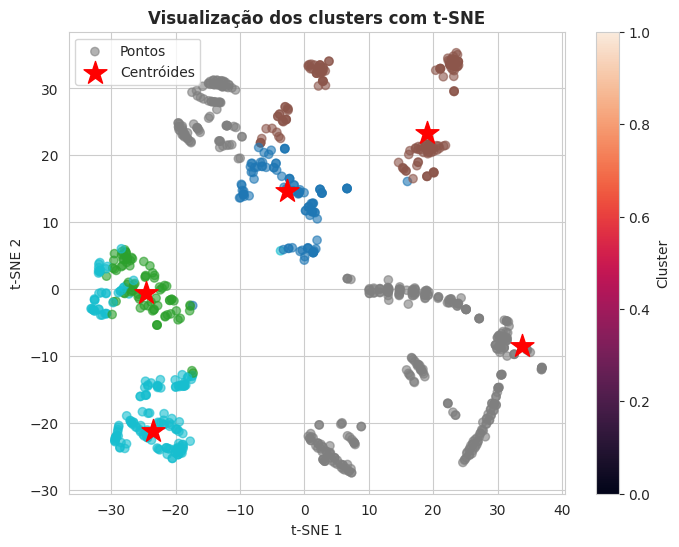

In [ ]:
from sklearn.manifold import TSNE
# Padronização
scaler = StandardScaler()
X_std = scaler.fit_transform(df_train_processed)

# KMeans
kmeans.fit(X_std)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# Combinar os dados com os centróides para projetar tudo junto
X_all = np.vstack([X_std, centroids])
X_all_tsne = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X_all)

# Separar os dados e os centróides
X_tsne = X_all_tsne[:-5]
centroids_tsne = X_all_tsne[-5:]

# Plotar
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='tab10', alpha=0.6, label='Pontos')
plt.scatter(centroids_tsne[:, 0], centroids_tsne[:, 1],
            c='red', marker='*', s=300, label='Centróides')
plt.title("Visualização dos clusters com t-SNE", fontweight='bold')
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.colorbar(label='Cluster')
plt.legend()
plt.grid(True)
plt.show()

####Análise dos Clusters (K-Means)

> Adicionar blockquote



Agora, vamos analisar as características de cada cluster formado.

Extração de Regras Descritivas com Árvore de Decisão

Para entender melhor a composição de cada cluster, podemos treinar uma Árvore de Decisão para classificar os passageiros nos grupos criados pelo K-Means.As regras da árvore nos darão uma descrição clara de cada grupo.

In [ ]:
# Usando os clusters do K-Means como o "alvo" para a árvore de decisão
X = df_train_processed.drop(columns=['Cluster_KMeans', 'Cluster_DBSCAN','Cluster_KPrototypes'], errors='ignore')
y = df_train_processed['Cluster_KMeans']

# Treinando a árvore de decisão
tree_classifier = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_classifier.fit(X, y)

# Extraindo e exibindo as regras
tree_rules = export_text(tree_classifier, feature_names=list(X.columns))
print("Regras da Árvore de Decisão para os Clusters do K-Means:")
print(tree_rules)

Regras da Árvore de Decisão para os Clusters do K-Means:
|--- Pclass <= -0.97
|   |--- Fare <= 1.70
|   |   |--- Age <= -1.49
|   |   |   |--- class: 2
|   |   |--- Age >  -1.49
|   |   |   |--- class: 0
|   |--- Fare >  1.70
|   |   |--- Fare <= 2.56
|   |   |   |--- class: 1
|   |   |--- Fare >  2.56
|   |   |   |--- class: 1
|--- Pclass >  -0.97
|   |--- Embarked <= 0.22
|   |   |--- Parch <= 0.15
|   |   |   |--- class: 4
|   |   |--- Parch >  0.15
|   |   |   |--- class: 2
|   |--- Embarked >  0.22
|   |   |--- Age <= -1.60
|   |   |   |--- class: 2
|   |   |--- Age >  -1.60
|   |   |   |--- class: 3



#### Conclusões sobre cada cluster
Cluster 0: 	O Passageiro Comum e Solitário (2ª/3ª Classe, viajando sem pais/filhos)

Cluster 1:	A Família Grande de Classe Baixa (2ª/3ª Classe, com muitos familiares)

Cluster 2:	A Família de Classe Média/Baixa (2ª/3ª Classe, com alguns familiares)

Cluster 3:	A Elite "Modesta" (1ª Classe, com tarifa mais baixa e poucos familiares)

Cluster 4: A Elite Rica (1ª Classe, com tarifa altíssima ou família maior)


### K-Prototypes

Este algoritmo é uma extensão do K-Means para lidar com dados mistos (numéricos e categóricos), o que é ideal para nosso dataset antes da normalização e one-hot encoding.

In [ ]:
# --- Preparação do DataFrame para o K-Prototypes ---
# O K-Prototypes é projetado para lidar com dados mistos (numéricos e categóricos)
# Portanto, não faremos o "one-hot encoding" das variáveis categóricas para este modelo.

# 1. Utilizar o dataframe original para garantir que estamos partindo dos dados brutos
try:
    df_kproto_source = pd.read_csv('train.csv')
    print("Dataset original 'train.csv' carregado com sucesso!")
except FileNotFoundError:
    print("Erro: Arquivo 'train.csv' não encontrado.")
    df_kproto_source = pd.DataFrame() # Cria um df vazio para evitar erros subsequentes

# 2. Criar uma cópia para o pré-processamento do K-Prototypes
df_kproto = df_kproto_source.copy()

# 3. Remover a coluna 'Survived' para a análise não supervisionada
if 'Survived' in df_kproto.columns:
    df_kproto = df_kproto.drop('Survived', axis=1)
    print("Coluna 'Survived' removida.")

# 4. Tratamento de dados faltantes (similar ao que foi feito para o K-Means)
# Idade ('Age'): preencher com a mediana
df_kproto['Age'].fillna(df_kproto['Age'].median(), inplace=True)
# Porto de Embarque ('Embarked'): preencher com a moda
df_kproto['Embarked'].fillna(df_kproto['Embarked'].mode()[0], inplace=True)

# 6. Remover colunas irrelevantes para a análise de padrões
df_kproto = df_kproto.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])

# 7. Identificar as posições (índices) das colunas categóricas
# O algoritmo KPrototypes da biblioteca 'kmodes' precisa saber quais colunas são categóricas pelo seu índice.
# As colunas categóricas que mantivemos são: Pclass, Sex, Embarked e a nova Has_Cabin.
# Pclass é numérica, mas representa uma categoria, então a tratamos como tal.

categorical_features_indices = [df_kproto.columns.get_loc(col) for col in ['Pclass', 'Sex', 'Embarked']]

print("\nPré-processamento para K-Prototypes concluído.")
print(f"Índices das colunas categóricas: {categorical_features_indices}")

# Exibir as primeiras linhas do dataframe pronto para o K-Prototypes
print("\nDataFrame para K-Prototypes:")
df_kproto.head()

Dataset original 'train.csv' carregado com sucesso!
Coluna 'Survived' removida.

Pré-processamento para K-Prototypes concluído.
Índices das colunas categóricas: [0, 1, 6]

DataFrame para K-Prototypes:


/tmp/ipython-input-2159086572.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_kproto['Age'].fillna(df_kproto['Age'].median(), inplace=True)
/tmp/ipython-input-2159086572.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inpl

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S


### DBSCAN

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) agrupa pontos que estão densamente empacotados, marcando como outliers os pontos que estão sozinhos em regiões de baixa densidade.

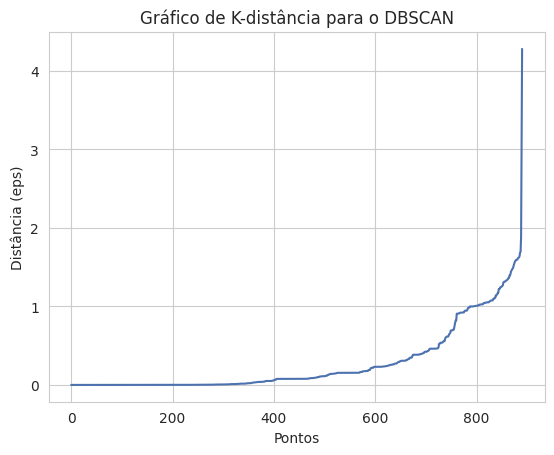

,count
Cluster_DBSCAN,
0,396
2,141
5,75
1,71
3,66
4,66
-1,56
6,8
7,7


In [ ]:
# Aplicando o DBSCAN
# A escolha de 'eps' é crucial. Um método comum é usar um gráfico de k-distância.
from sklearn.neighbors import NearestNeighbors

# Calculando a distância para os 2*n_features vizinhos mais próximos
neighbors = NearestNeighbors(n_neighbors=2 * df_train_processed.shape[1])
neighbors_fit = neighbors.fit(df_train_processed)
distances, indices = neighbors_fit.kneighbors(df_train_processed)

# Ordenando e plotando as distâncias
distances = np.sort(distances, axis=0)
distances = distances[:, 1]
plt.plot(distances)
plt.title('Gráfico de K-distância para o DBSCAN')
plt.xlabel('Pontos')
plt.ylabel('Distância (eps)')
plt.show()

# Com base no gráfico, escolhemos um 'eps' e 'min_samples'
dbscan = DBSCAN(eps=1.5, min_samples=5)
clusters_dbscan = dbscan.fit_predict(df_train_processed)

# Adicionando os clusters ao dataframe
df_train_processed['Cluster_DBSCAN'] = clusters_dbscan

# Análise dos clusters (incluindo o cluster -1, que representa ruído/outliers)
df_train_processed['Cluster_DBSCAN'].value_counts()

###Análise dos clusters (DBSCAN)

In [ ]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import numpy as np

# labels do DBSCAN (feito anteriormente)
labels_dbscan = clusters_dbscan

# Verifica se existem ao menos 2 clusters válidos
n_clusters = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)

if n_clusters > 1:
    silhouette = silhouette_score(df_train_processed, labels_dbscan)
    calinski = calinski_harabasz_score(df_train_processed, labels_dbscan)
    davies = davies_bouldin_score(df_train_processed, labels_dbscan)

    print(f"Silhouette Score: {silhouette:.3f}")
    print(f"Calinski-Harabasz Score: {calinski:.3f}")
    print(f"Davies-Bouldin Score: {davies:.3f}")
else:
    print("Não é possível calcular métricas com apenas um cluster.")

Silhouette Score: 0.459
Calinski-Harabasz Score: 303.422
Davies-Bouldin Score: 1.034


Extração de Regras Descritivas com Árvore de Decisão (DBSCAN)


In [ ]:
from sklearn.tree import DecisionTreeClassifier, export_text

# Remova os clusters de outros métodos (se existirem)
X = df_train_processed.drop(columns=['Cluster_KMeans', 'Cluster_KPrototypes', 'Cluster_DBSCAN'], errors='ignore')
y = df_train_processed['Cluster_DBSCAN']

# Retira outliers (-1) para a árvore
mask_valid = y != -1
X_valid = X[mask_valid]
y_valid = y[mask_valid]

# Treina a árvore
tree_classifier = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_classifier.fit(X_valid, y_valid)

# Exibe as regras
rules = export_text(tree_classifier, feature_names=list(X_valid.columns))
print("Regras da Árvore de Decisão para os Clusters do DBSCAN:")
print(rules)

Regras da Árvore de Decisão para os Clusters do DBSCAN:
|--- Embarked <= 0.22
|   |--- Pclass <= -0.97
|   |   |--- Parch <= 1.39
|   |   |   |--- class: 2
|   |   |--- Parch >  1.39
|   |   |   |--- class: 8
|   |--- Pclass >  -0.97
|   |   |--- Parch <= 0.15
|   |   |   |--- class: 0
|   |   |--- Parch >  0.15
|   |   |   |--- class: 4
|--- Embarked >  0.22
|   |--- Pclass <= -0.97
|   |   |--- class: 1
|   |--- Pclass >  -0.97
|   |   |--- Embarked <= 1.79
|   |   |   |--- class: 5
|   |   |--- Embarked >  1.79
|   |   |   |--- class: 3



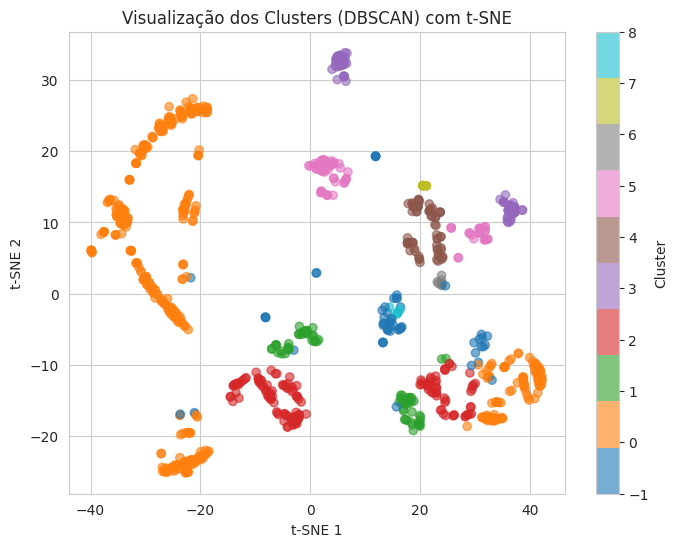

In [ ]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Normaliza os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_train_processed.drop(columns=['Cluster_DBSCAN'], errors='ignore'))

# Aplica t-SNE
X_tsne = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X_scaled)

# Plota
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels_dbscan, cmap='tab10', alpha=0.6)
plt.title("Visualização dos Clusters (DBSCAN) com t-SNE")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

####Análise dos Clusters (K-Prototypes)


Usando T-SNE para analisar os clusters

Extração de Regras Descritivas com Árvore de Decisão com K-Prototypes

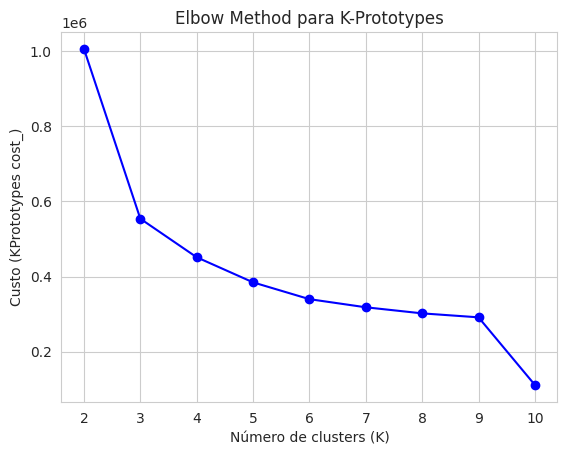

In [ ]:
from kmodes.kprototypes import KPrototypes
import matplotlib.pyplot as plt

costs = []
k_range = range(2, 11)

for k in k_range:
    kproto = KPrototypes(n_clusters=k, init='Cao', verbose=0, random_state=42)
    clusters = kproto.fit_predict(df_kproto, categorical=categorical_features_indices)
    costs.append(kproto.cost_)

# Plotar o custo vs K (parecido com Elbow Method)
plt.plot(k_range, costs, 'bo-')
plt.xlabel('Número de clusters (K)')
plt.ylabel('Custo (KPrototypes cost_)')
plt.title('Elbow Method para K-Prototypes')
plt.grid(True)
plt.show()

**Usando** TSNE para visualizar os clusters:

In [ ]:
best_k_kproto = 3

kproto = KPrototypes(n_clusters=best_k_kproto, init='Cao', verbose=0, random_state=42)
clusters_kproto = kproto.fit_predict(df_kproto, categorical=categorical_features_indices)

# Salvar os rótulos no dataframe original
df_kproto['Cluster_KPrototypes'] = clusters_kproto

In [ ]:
from sklearn.tree import DecisionTreeClassifier, export_text

# Prepara os dados (codificando categorias para árvore)
df_kproto_encoded = pd.get_dummies(df_kproto.drop(columns=['Cluster_KPrototypes']), drop_first=True)
X = df_kproto_encoded
y = df_kproto['Cluster_KPrototypes']

# Treina a árvore
tree_classifier = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_classifier.fit(X, y)

# Exibe as regras
rules = export_text(tree_classifier, feature_names=list(X.columns))
print("Regras da Árvore de Decisão para os Clusters do K-Prototypes:")
print(rules)

Regras da Árvore de Decisão para os Clusters do K-Prototypes:
|--- Fare <= 49.50
|   |--- class: 1
|--- Fare >  49.50
|   |--- Fare <= 188.10
|   |   |--- Fare <= 49.75
|   |   |   |--- class: 1
|   |   |--- Fare >  49.75
|   |   |   |--- class: 2
|   |--- Fare >  188.10
|   |   |--- class: 0



Usando TSNE para visualizar os clusters:

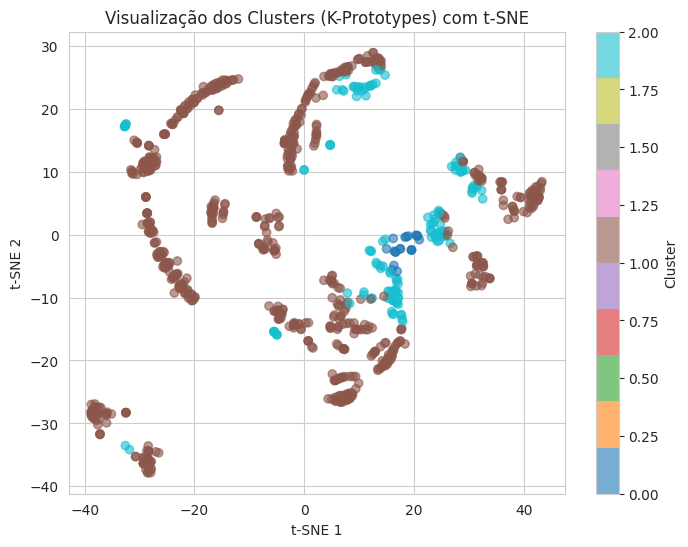

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

# Codificar e normalizar
X_encoded = pd.get_dummies(df_kproto.drop(columns=['Cluster_KPrototypes']), drop_first=True)
X_scaled = StandardScaler().fit_transform(X_encoded)

# t-SNE
X_tsne = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X_scaled)

# Plotar
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=clusters_kproto, cmap='tab10', alpha=0.6)
plt.title("Visualização dos Clusters (K-Prototypes) com t-SNE")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()